In [1]:
import numpy as np
import pandas as pd
import psycopg2
import sqlalchemy
import matplotlib.pyplot as plt

In [2]:
import config
from sqlalchemy import create_engine

cnx = create_engine(config.postgres_str)

In [3]:
head = pd.read_sql_query('''SELECT * FROM hpd_violations LIMIT 100;''', cnx)
head.columns

Index(['violationid', 'buildingid', 'registrationid', 'boroid', 'borough',
       'housenumber', 'lowhousenumber', 'highhousenumber', 'streetname',
       'streetcode', 'postcode', 'apartment', 'story', 'block', 'lot', 'class',
       'inspectiondate', 'approveddate', 'originalcertifybydate',
       'originalcorrectbydate', 'newcertifybydate', 'newcorrectbydate',
       'certifieddate', 'ordernumber', 'novid', 'novdescription',
       'novissueddate', 'currentstatusid', 'currentstatus',
       'currentstatusdate', 'novtype', 'violationstatus', 'latitude',
       'longitude', 'communityboard', 'councildistrict', 'censustract', 'bin',
       'bbl', 'nta'],
      dtype='object')

In [4]:
top_violators = pd.read_sql_query('''SELECT count(*), buildingid FROM hpd_violations GROUP BY buildingid HAVING COUNT(*) > 1 LIMIT 500;''', cnx)
top_100 = top_violators.sort_values(by=['count'], ascending = False).head(100)
top_100

,count,buildingid
318,1010,5378
218,772,81857
369,579,92616
381,510,491277
192,453,40954
112,437,64090
131,386,337901
441,368,59926
401,361,43016
374,285,21312


# use bbl to visualize on a map

In [5]:
top100_buildingids = top_100['buildingid']
top100_buildingids.head()

318      5378
218     81857
369     92616
381    491277
192     40954
Name: buildingid, dtype: int64

In [6]:
# df with all the violations on top 100 buildingid
top100_df = pd.read_sql_query(f'''SELECT * FROM hpd_violations WHERE buildingid = {top100_buildingids[0]}''', cnx)

In [7]:
for i in range(1, len(top100_buildingids)):
    temp = pd.read_sql_query(f'''SELECT * FROM hpd_violations WHERE buildingid = {top100_buildingids.iloc[i]}''', cnx)
    top100_df = pd.concat([top100_df, temp])
top100_df['buildingid'].unique()

array([909820,  81857,  92616, 491277,  40954,  64090, 337901,  59926,
        43016,  21312, 428409, 209483, 309621,  28015, 187420, 115231,
       292856, 348545, 280157, 812433,  41887, 112833, 808241, 362833,
       161569,  73800,  56824, 332466,  40971, 112516,  73719, 186195,
        21273,  45433,  66093,   5682, 373078, 295966,  44088, 371724,
       309139, 408778,  62215, 299120, 296558, 427765, 733699,  19130,
       363406,  73672, 509336, 373513, 379928, 460495, 359803,  27721,
        39256, 398829,  56255, 240473, 121331, 818167, 461388, 312123,
       957363,  39154, 339313, 268499, 203922,  28365, 351644, 217582,
       675171, 213576, 890315,  59315, 217258,  31276,  58985, 660468,
        96295, 417170, 114196, 305979, 349528, 347770, 559270, 357648,
        82081, 179627, 343596, 117113, 208106,  36049, 527559, 421707,
       347464, 334145, 222393], dtype=int64)

In [8]:
top100_df.shape

(12942, 40)

In [9]:
top100_bbl = top100_df['bbl'].unique()

1. Make my own representation to plot on map
2. Address to coordinates
3. Implement some tolerane range around the address

In [10]:
top100_longitude = top100_df['longitude'].unique()
top100_latitude = top100_df['latitude'].unique()
top100_latitude

array([40.784767, 40.865154, 40.855513, 40.689512, 40.821122, 40.817256,
       40.671929, 40.85253 , 40.838081, 40.835435, 40.760703, 40.667398,
       40.661855, 40.852638, 40.641216, 40.812191, 40.65758 , 40.641659,
       40.641007, 40.644217, 40.820968, 40.835793, 40.670361, 40.663608,
       40.629793, 40.871942, 40.831927, 40.676784, 40.815771, 40.8413  ,
       40.882479, 40.678271, 40.826081, 40.836484, 40.849915, 40.828262,
       40.68137 , 40.673707, 40.792347, 40.67883 , 40.711264, 40.772795,
       40.843057, 40.694883, 40.64442 , 40.753783, 40.645021, 40.789971,
       40.708418, 40.870606, 40.758072, 40.687958, 40.672338, 40.743911,
       40.686132, 40.725073, 40.805914, 40.66406 , 40.831011, 40.645375,
       40.871844, 40.674976, 40.723974, 40.707949, 40.795886, 40.807525,
       40.684895, 40.654845, 40.602996, 40.721073, 40.671841, 40.666599,
       40.705981, 40.653777, 40.636631, 40.870559, 40.695393, 40.744132,
       40.8207  , 40.704646, 40.843463, 40.764677, 

In [11]:
import gmplot
gmap = gmplot.GoogleMapPlotter(top100_latitude.mean(), top100_longitude.mean(), 12)
gmap.scatter(top100_latitude, top100_longitude, '# FF0000',
             size=40, marker=True)

gmap.draw('./map1.html')
print(top100_latitude.mean())

40.737831161616164


In [12]:
coords = list(zip(top100_longitude, top100_latitude))

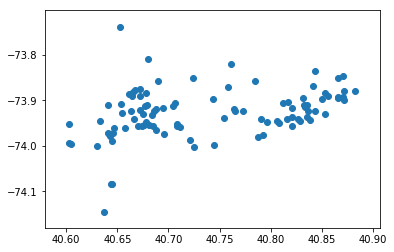

In [13]:
plt.scatter(top100_latitude, top100_longitude)
plt.show()

# Plotting on map

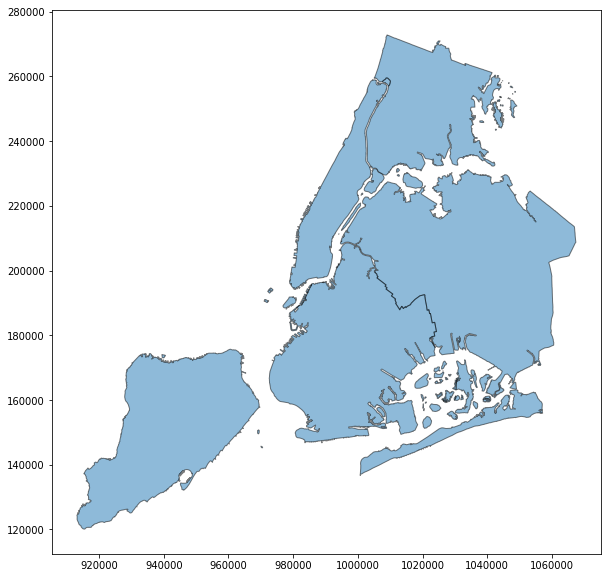

In [14]:
import geopandas

nyc_map = geopandas.read_file(geopandas.datasets.get_path('nybb'))
ax = nyc_map.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
nyc_map = nyc_map.to_crs(epsg=3857)

In [15]:
import contextily as ctx

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))   

In [16]:
from shapely.geometry import Point
top100_df['coordinates'] = list(zip(top100_df.longitude, top100_df.latitude))

In [17]:
top100_df['coordinates'] = top100_df['coordinates'].apply(Point)

In [18]:
# crs = {'init':'epsg:3857'}
gdf = geopandas.GeoDataFrame(top100_df, geometry='coordinates')
gdf

,violationid,buildingid,registrationid,boroid,borough,housenumber,lowhousenumber,highhousenumber,streetname,streetcode,...,violationstatus,latitude,longitude,communityboard,councildistrict,censustract,bin,bbl,nta,coordinates
0,10944968,909820,428929,4,QUEENS,14-34,14-34,14-34,110 STREET,20390,...,Open,40.784767,-73.856840,7,19,929,4534917,4040447501,College Point,POINT (-73.85684000000001 40.784767)
1,10944969,909820,428929,4,QUEENS,14-34,14-34,14-34,110 STREET,20390,...,Open,40.784767,-73.856840,7,19,929,4534917,4040447501,College Point,POINT (-73.85684000000001 40.784767)
2,10971042,909820,428929,4,QUEENS,14-34,14-34,14-34,110 STREET,20390,...,Close,40.784767,-73.856840,7,19,929,4534917,4040447501,College Point,POINT (-73.85684000000001 40.784767)
3,11545535,909820,428929,4,QUEENS,14-34,14-34,14-34,110 STREET,20390,...,Close,40.784767,-73.856840,7,19,929,4534917,4040447501,College Point,POINT (-73.85684000000001 40.784767)
4,11885868,909820,428929,4,QUEENS,14-34,14-34,14-34,110 STREET,20390,...,Open,40.784767,-73.856840,7,19,929,4534917,4040447501,College Point,POINT (-73.85684000000001 40.784767)
5,11885881,909820,428929,4,QUEENS,14-34,14-34,14-34,110 STREET,20390,...,Close,40.784767,-73.856840,7,19,929,4534917,4040447501,College Point,POINT (-73.85684000000001 40.784767)
6,11885873,909820,428929,4,QUEENS,14-34,14-34,14-34,110 STREET,20390,...,Open,40.784767,-73.856840,7,19,929,4534917,4040447501,College Point,POINT (-73.85684000000001 40.784767)
7,11885887,909820,428929,4,QUEENS,14-34,14-34,14-34,110 STREET,20390,...,Close,40.784767,-73.856840,7,19,929,4534917,4040447501,College Point,POINT (-73.85684000000001 40.784767)
8,11885888,909820,428929,4,QUEENS,14-34,14-34,14-34,110 STREET,20390,...,Close,40.784767,-73.856840,7,19,929,4534917,4040447501,College Point,POINT (-73.85684000000001 40.784767)
9,11885876,909820,428929,4,QUEENS,14-34,14-34,14-34,110 STREET,20390,...,Open,40.784767,-73.856840,7,19,929,4534917,4040447501,College Point,POINT (-73.85684000000001 40.784767)


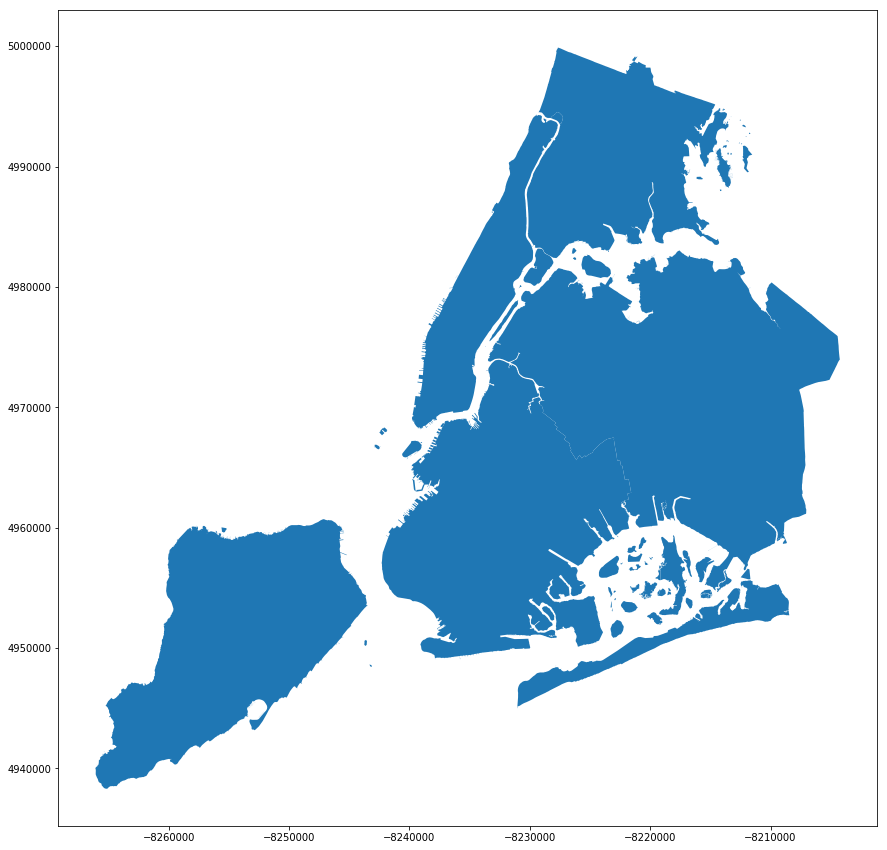

In [19]:
# ax = nyc_map.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
# gdf.plot(ax=ax, markersize=1, color='red', marker='o', label='Violation')
# add_basemap(ax, zoom=10) 
fig, ax = plt.subplots(figsize=(15,15))
nyc_map.plot(ax=ax)

http://geopandas.org/gallery/create_geopandas_from_pandas.html#from-longitudes-and-latitudes

In [27]:
gdf['coordinates'].head()

0    POINT (-73.85684000000001 40.784767)
1    POINT (-73.85684000000001 40.784767)
2    POINT (-73.85684000000001 40.784767)
3    POINT (-73.85684000000001 40.784767)
4    POINT (-73.85684000000001 40.784767)
Name: coordinates, dtype: object

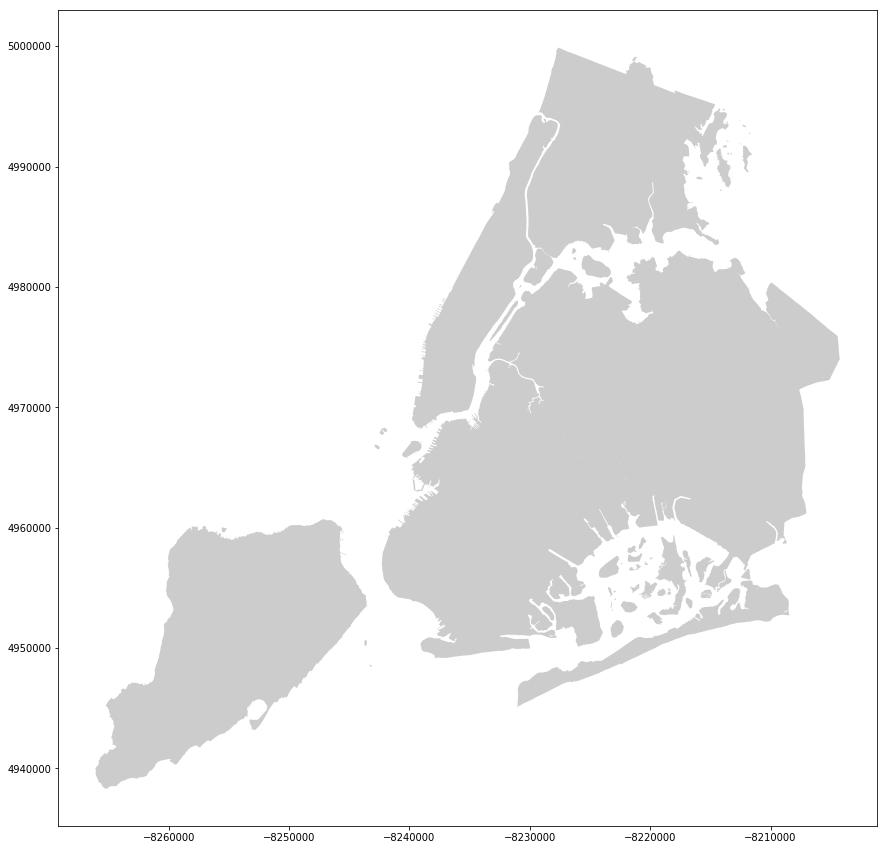

In [24]:
fig, ax = plt.subplots(figsize=(15,15))
nyc_map.plot(ax=ax, alpha=0.4, color='grey')
#gdf.plot(ax=ax, markersize=20, color='red', marker='o', label='violation')

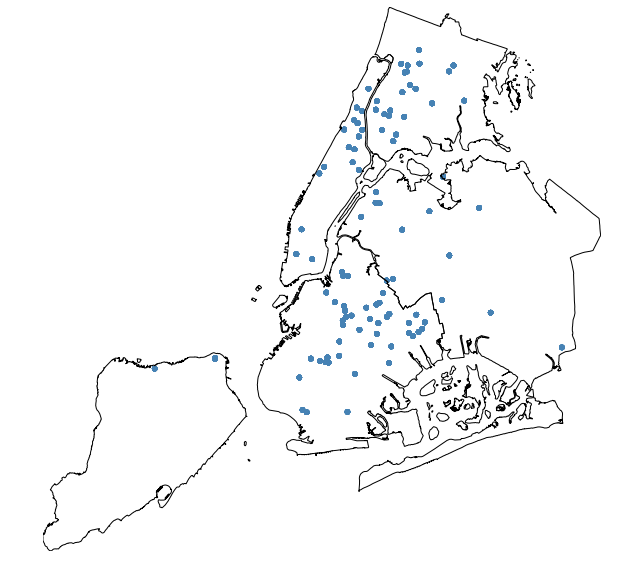

In [34]:
# Need to scale the map to match the coordinates space (roughly from -100 to +100 for both long. and lat.)
# trying using http://geopandas.org/gallery/plotting_with_geoplot.html
import geoplot

boroughs = geopandas.read_file(geopandas.datasets.get_path('nybb')).to_crs(epsg='4326')
ax = geoplot.pointplot(gdf, figsize=(10, 10))
geoplot.polyplot(boroughs, ax=ax)